In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
%matplotlib inline


train_set = pd.read_csv('data/train.csv')

print('Total number of question pairs before cleaning: {}'.format(len(train_set)))

#Fill NaN

train_set = train_set.dropna()

print('Total number of question pairs after dropna(): {}'.format(len(train_set)))

#Stop words

stop_words = set(stopwords.words('english'))

def filter_stopwords(row):

    word_tokens = word_tokenize(row)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = ' '.join(filtered_sentence)
    return filtered_sentence

train_set.head()

Total number of question pairs before cleaning: 404290
Total number of question pairs after dropna(): 404288


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [2]:
#Quick dataset summary, to complete with visualizations

print('Total number of question pairs for training: {}'.format(len(train_set)))

print('Duplicate pairs: {}%'.format(round(train_set['is_duplicate'].mean()*100, 2)))

qids = pd.Series(train_set['qid1'].tolist() + train_set['qid2'].tolist())

print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))

print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of question pairs for training: 404288
Duplicate pairs: 36.92%
Total number of questions in the training data: 537931
Number of questions that appear multiple times: 111778


In [4]:
#First feature idea: the %ge of similar words in both sentences.
#Let's use a convenient function found in Anokas' kernel.
#https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

train_set['word_match_share'] = train_set.apply(word_match_share, axis=1, raw=True)
train_word_match = train_set.apply(word_match_share, axis=1, raw=True)

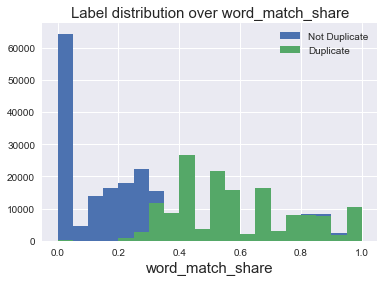

In [5]:
#Let's plot the results.

plt.hist(train_word_match[train_set['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[train_set['is_duplicate'] == 1], bins=20, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [6]:
#TfIDFVectorizer: Let's group our sentences in one column and use TF-IDF Vectorizer
#to identify uncommon words (which will have more signal than common words)

train_set['concat_q1q2'] = train_set.question1 + train_set.question2
train_set['concat_q1q2'] = train_set.concat_q1q2.apply(lambda x:
                                                      ''.join([word for word in x if not word.isdigit()]).replace('_',''))

vectorizer = TfidfVectorizer(min_df=2)

X = vectorizer.fit_transform(train_set['concat_q1q2'])
idf = vectorizer.idf_
idf_dict = dict(zip(vectorizer.get_feature_names(), idf))

In [7]:
print('Most common words and weights: \n')
print(sorted(idf_dict.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(idf_dict.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 1.6608632720729619), ('what', 1.6673504982142688), ('is', 1.785765883867596), ('how', 2.0009795138723843), ('to', 2.0854464441893161), ('in', 2.1413335525701971), ('do', 2.2182614485928336), ('of', 2.313124276857101), ('are', 2.348302960822914), ('and', 2.4662026855114947)]

Least common words and weights: 


[('aadaab', 12.811272959071452),
 ('aadmk', 12.811272959071452),
 ('aadvantage', 12.811272959071452),
 ('aae', 12.811272959071452),
 ('aaj', 12.811272959071452),
 ('aalto', 12.811272959071452),
 ('aamdaar', 12.811272959071452),
 ('aane', 12.811272959071452),
 ('aanika', 12.811272959071452),
 ('aankho', 12.811272959071452)]

C:\Users\Mehdi\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mehdi\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


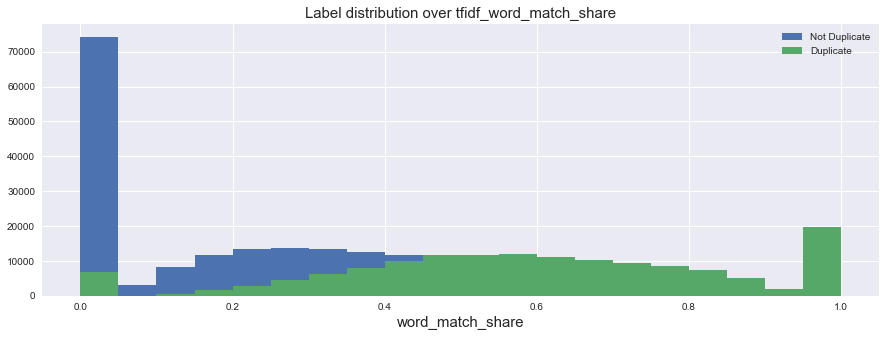

In [8]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [idf_dict.get(w, 0) for w in q1words.keys() if w in q2words] + [idf_dict.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [idf_dict.get(w, 0) for w in q1words] + [idf_dict.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

train_set['tfidf_word_match_share'] = train_set.apply(tfidf_word_match_share, axis=1, raw=True)

plt.figure(figsize=(15, 5))
tfidf_train_word_match = train_set.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[train_set['is_duplicate'] == 0].fillna(0), bins=20, label='Not Duplicate')
plt.hist(tfidf_train_word_match[train_set['is_duplicate'] == 1].fillna(0), bins=20, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [9]:
#Let's add some basic features such as sentence length and word count

train_set['q1len'] = train_set['question1'].str.len()
train_set['q2len'] = train_set['question2'].str.len()

train_set['q1_n_words'] = train_set['question1'].apply(lambda row: len(row.split(" ")))
train_set['q2_n_words'] = train_set['question2'].apply(lambda row: len(row.split(" ")))

In [12]:
#Now let's calculate the lemmas_match_share and see if it looks like a powerful feature.

#Step 1: tokenize each sentence and run POS tagging on it (nltk.pos_tag()) cf tuto Notebook

train_set['q1token'] = train_set.question1.apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
train_set['q2token'] = train_set.question2.apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

#Step 2: use the lemmatizer and the get_wordnet_pos function (to convert the output from pos_tag())

lem = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

train_set['q1_lemmas'] = train_set.q1token.apply(lambda x: ' '.join([lem.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x]))
train_set['q2_lemmas'] = train_set.q2token.apply(lambda x: ' '.join([lem.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x]))

In [15]:
#Step 3: calculate the lemmas_match_share feature using the same model as word_match_share

def lemmas_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['q1_lemmas']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['q2_lemmas']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

train_set['lemmas_match_share'] = train_set.apply(lemmas_match_share, axis=1, raw=True)
train_lemmas_match = train_set.apply(lemmas_match_share, axis=1, raw=True)

train_set.head(10)

,id,qid1,qid2,question1,question2,is_duplicate,word_match_share,concat_q1q2,tfidf_word_match_share,q1len,q2len,q1_n_words,q2_n_words,q1token,q2token,q1_lemmas,q2_lemmas,lemmas_match_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.727273,What is the step by step guide to invest in sh...,0.902847,66,57,14,12,"[(What, WP), (is, VBZ), (the, DT), (step, NN),...","[(What, WP), (is, VBZ), (the, DT), (step, NN),...",What be the step by step guide to invest in sh...,What be the step by step guide to invest in sh...,0.923077
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.307692,What is the story of Kohinoor (Koh-i-Noor) Dia...,0.325130,51,88,8,13,"[(What, WP), (is, VBZ), (the, DT), (story, NN)...","[(What, WP), (would, MD), (happen, VB), (if, I...",What be the story of Kohinoor ( Koh-i-Noor ) D...,What would happen if the Indian government ste...,0.631579
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.363636,How can I increase the speed of my internet co...,0.423591,73,59,14,10,"[(How, WRB), (can, MD), (I, PRP), (increase, V...","[(How, WRB), (can, MD), (Internet, NNP), (spee...",How can I increase the speed of my internet co...,How can Internet speed be increase by hack thr...,0.615385
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,Why am I mentally very lonely? How can I solve...,0.000000,50,65,11,9,"[(Why, WRB), (am, VBP), (I, PRP), (mentally, R...","[(Find, IN), (the, DT), (remainder, NN), (when...",Why be I mentally very lonely ? How can I solv...,Find the remainder when [ math ] 23^ { 24 } [ ...,0.117647
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.000000,"Which one dissolve in water quikly sugar, salt...",0.000000,76,39,13,7,"[(Which, WDT), (one, CD), (dissolve, NN), (in,...","[(Which, JJ), (fish, NN), (would, MD), (surviv...","Which one dissolve in water quikly sugar , sal...",Which fish would survive in salt water ?,0.333333
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,0.470588,Astrology: I am a Capricorn Sun Cap moon and c...,0.568497,86,90,16,16,"[(Astrology, NN), (:, :), (I, PRP), (am, VBP),...","[(I, PRP), ('m, VBP), (a, DT), (triple, JJ), (...",Astrology : I be a Capricorn Sun Cap moon and ...,"I 'm a triple Capricorn ( Sun , Moon and ascen...",0.476190
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,0.000000,Should I buy tiago?What keeps childern active ...,0.000000,19,62,4,11,"[(Should, MD), (I, PRP), (buy, VB), (tiago, IN...","[(What, WP), (keeps, VBZ), (childern, JJ), (ac...",Should I buy tiago ?,What keep childern active and far from phone a...,0.181818
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,0.500000,How can I be a good geologist?What should I do...,0.000000,30,41,7,9,"[(How, WRB), (can, MD), (I, PRP), (be, VB), (a...","[(What, WP), (should, MD), (I, PRP), (do, VB),...",How can I be a good geologist ?,What should I do to be a great geologist ?,0.666667
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,0.500000,When do you use シ instead of し?When do you use...,1.000000,31,37,8,8,"[(When, WRB), (do, VBP), (you, PRP), (use, VB)...","[(When, WRB), (do, VBP), (you, PRP), (use, VB)...",When do you use シ instead of し ?,When do you use `` & '' instead of `` and '' ?,0.545455
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,0.363636,Motorola (company): Can I hack my Charter Moto...,0.676262,60,49,9,9,"[(Motorola, NNP), ((, (), (company, NN), (), )...","[(How, WRB), (do, VBP), (I, PRP), (hack, VB), ...",Motorola ( company ) : Can I hack my Charter M...,How 

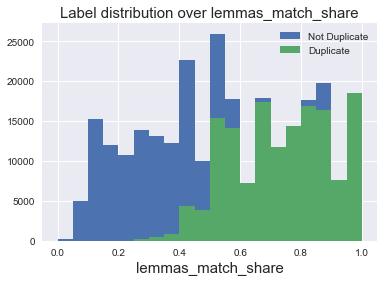

In [17]:
#Let's plot the results.

plt.hist(train_lemmas_match[train_set['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_lemmas_match[train_set['is_duplicate'] == 1], bins=20, label='Duplicate')
plt.legend()
plt.title('Label distribution over lemmas_match_share', fontsize=15)
plt.xlabel('lemmas_match_share', fontsize=15)

In [ ]:
#Unfortunately using the lemmas for calculating the lemmas_match_share isn't a really usful feature (actually makes the model
#perform worse)

#We can try to use the wordnet similarity function to determine - in cases in which a few words differ - if there's an important
#similarity between words of the same type (nouns, verbs, adv). However, this time let's first quickly check over the training set
#whether we have an important share of questions diverging by only a few words, ideally 2 or 3.

LogisticRegression score: 0.675691139177
LogisticRegression logloss: 0.551089291034
Naive Bayes score: 0.681217754126
Naive Bayes logloss: 0.932824743339
Decision Tree score: 0.734230283951
Decision Tree logloss: 0.468917448187


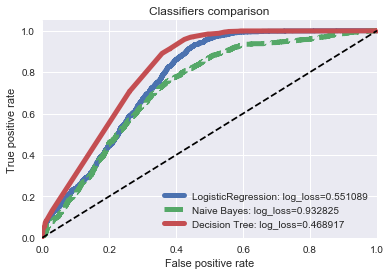

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

#Evaluation of best model using ROC curve and AUC

features = ['word_match_share', 'tfidf_word_match_share', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words']


CLASS_MAP = {
    'LogisticRegression' : ('-', LogisticRegression()),
    'Naive Bayes' : ('--', GaussianNB()),
    'Decision Tree': ('.-', DecisionTreeClassifier(max_depth=5)),
    #'Random Forest': (':', RandomForestClassifier())
}

param_grid = {
             'max_depth': [2, 5, 6],
             'max_features': [2, 5, 6]
         }

scl = StandardScaler()

target = train_set['is_duplicate'] == 1

feat = train_set[features].fillna(0)
feat = pd.get_dummies(feat)

X, Y = feat, target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =.01)

X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

for name, (line_fmt, model) in CLASS_MAP.items():

    if name == 'Random Forest':
        model = GridSearchCV(model, param_grid, cv=3)

    model.fit(X_train, Y_train)
    preds = model.predict_proba(X_test)
    pred = pd.Series(preds[:,1])
    fpr, tpr, thresholds = roc_curve(Y_test, pred)
    auc_score = auc(fpr, tpr)
    classic_score = model.score(X_train, Y_train)
    logloss_score = log_loss(Y_test, pred)
    display_score = name + " score: " + str(classic_score)
    display_logloss = name + " logloss: " + str(logloss_score)
    print(display_score + '\n' + display_logloss)
    label = '%s: log_loss=%f' % (name, logloss_score)
    plt.plot(fpr, tpr, line_fmt, linewidth=5, label=label)

plt.legend(loc="lower right")
plt.title("Classifiers comparison")
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()